In [5]:
#Code from https://github.com/qiskit-community/ibm-quantum-challenge-spring-2023/blob/main/solutions/lab_3/lab3_solution.ipynb

In [59]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from scipy.optimize import curve_fit
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

theta = 2*np.pi*(3/8)

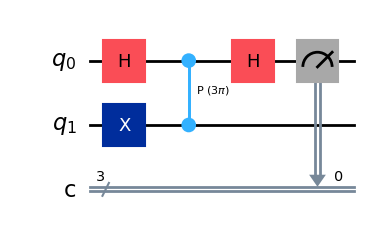

In [7]:
def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ########## your code goes here #######

    ##1 Initialization

    q0, q1 = qr
    # apply Hadamard on the auxiliary qubit
    qc.h(q0)
    # put the system qubit into the |1> state
    qc.x(q1)

    ##2 Apply control-U operator as many times as needed to get the least significant phase bit

    # we want to apply controlled-S 2^k times
    k = 2
    # calculate the angle of CPhase corresponding to 2^k applications of angle
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##3 Measure the auxiliary qubit in x-basis into the first classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    c0, _, _ = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr, theta)
qc.draw("mpl")

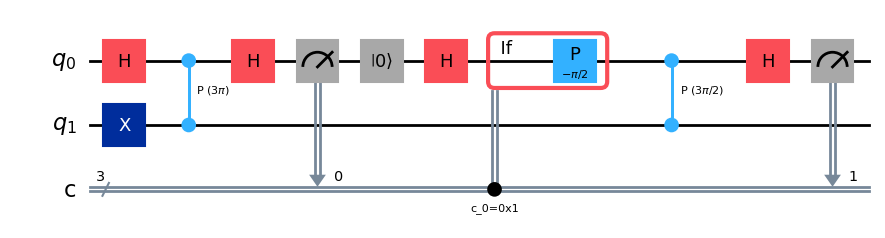

In [8]:
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr, angle)

    ########## your code goes here #######

    ##1 Reset and re-initialize the auxiliary qubit

    q0, q1 = qr
    # reset the auxiliary qubit
    qc.reset(q0)
    # apply Hadamard on the auxiiliary qubit
    qc.h(q0)

    ##2 Apply phase correction conditioned on the first classical bit

    c0, c1, _ = cr
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    ##3 Apply control-U operator as many times as needed to get the next phase bit

    # we want to apply controlled-S 2^k times
    k = 1
    # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##4 Measure the auxiliary qubit in x-basis into the second classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr, theta)
qc.draw("mpl")

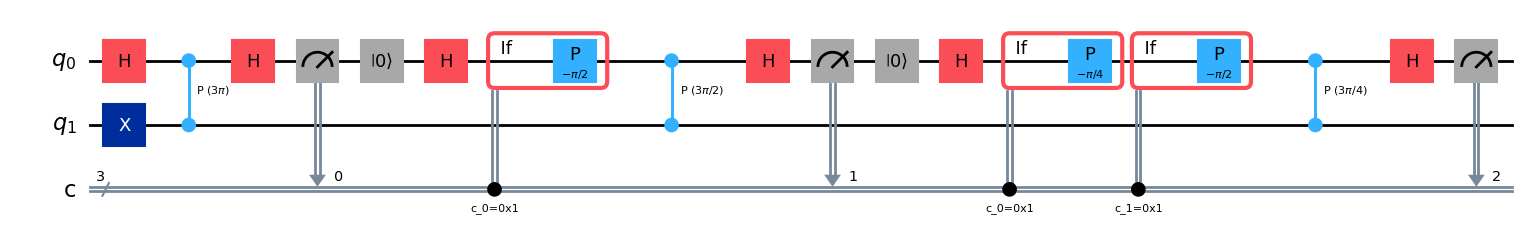

In [9]:
def step_3_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_2_circuit(qr, cr, angle)

    ########## your code goes here #######

    ##1 Reset and re-initialize the auxiliary qubit

    q0, q1 = qr
    # reset the auxiliary qubit
    qc.reset(q0)
    # apply Hadamard on the auxiiliary qubit
    qc.h(q0)

    ##2 Apply phase correction conditioned on the first classical bit

    c0, c1, c2 = cr
    with qc.if_test((c0, 1)):
        qc.p(-np.pi/4, q0)

    with qc.if_test((c1, 1)):
        qc.p(-np.pi/2, q0)

    ##3 Apply control-U operator as many times as needed to get the next phase bit

    # we want to apply controlled-S 2^k times
    k = 0
    # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##4 Measure the auxiliary qubit in x-basis into the second classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    qc.measure(q0, c2)

    return qc

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = step_3_circuit(qr, cr, theta)
qc.draw("mpl")

In [61]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
#counts

In [62]:
def iqpe(angle: float, steps: int):
    if steps == 1:
        qr = QuantumRegister(2, "q")
        cr = ClassicalRegister(3, "c")
        return step_1_circuit(qr,cr,angle)                  #funktioniert!!! (step_1_circuit will immer genau 3 classical registers haben, also zwei sind "überflüssuig", das kommt noch von mir, als ich den set_3 erweitert habe)
    else:
        qr = QuantumRegister(2,"q")
        cr = ClassicalRegister(steps, "c")
        q0, q1 = qr

        list = []
        for i in range(97, 97+steps):                               #hier die Liste mit dem Classical Register: Nachteil geht nur von A-Z, d.h. maximal 26 Steps, aber kann man theoretisch beliebig erweitern
            list.append("{:c}".format(i))
        list = cr  

        qc = QuantumCircuit(qr,cr)

        # apply Hadamard on the auxiliary qubit                                             
        qc.h(q0)
        # put the system qubit into the |1> state
        qc.x(q1)
        ##2 Apply control-U operator as many times as needed to get the least significant phase bit
        # we want to apply controlled-S 2^k times
        k = steps-1
        # calculate the angle of CPhase corresponding to 2^k applications of angle
        cphase_angle = angle * 2**k
        # apply the controlled phase gate
        qc.cp(cphase_angle, q0, q1)
        ##3 Measure the auxiliary qubit in x-basis into the first classical bit
        # apply Hadamard to change to the X basis
        qc.h(q0)
        # measure the auxiliary qubit into the first classical bit
                                 
        qc.measure(q0, list[0])                                                                                                     #Bis hier, nur step_1_cicuit

        for i in range(1,steps):                                                                                                    #Ab hier, gehts weiter über die for schleife
            qc.reset(q0)
            # apply Hadamard on the auxiiliary qubit
            qc.h(q0)

            ##2 Apply phase correction conditioned on the first classical bit

            for j in range(i):
                with qc.if_test((list[j], 1)):
                    qc.p((-2*np.pi)/(2**(i-j+1)), q0)

            ##3 Apply control-U operator as many times as needed to get the next phase bit

            # we want to apply controlled-S 2^k times
            k = steps - i - 1
            # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
            cphase_angle = angle * 2**k
            # apply the controlled phase gate
            qc.cp(cphase_angle, q0, q1)

            ##4 Measure the auxiliary qubit in x-basis into the second classical bit

            # apply Hadamard to change to the X basis
            qc.h(q0)
            # measure the auxiliary qubit into the first classical bit
            qc.measure(q0, list[i])
        
        return qc
#Funktioniert
def convert(bin: str):
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n
#Funktioniert
def mean(x: list, y: list):


    m = 0
    total = 0
    for i in range(len(x)):
        m += x[i]*y[i]
        total += y[i]
    m = m*(1/total)
    return m
#Funktioniert
def diff_with_max(x: list, y: list, angle: float):
    ind = 0
    max_element = y[0]
    for i in range (1,len(y)):
        if y[i] > max_element:
            max_element = y[i]
            ind = i
    diff_max = np.abs(x[ind] - angle)
    return diff_max

{'101': 19, '110': 17, '100': 59, '000': 14, '010': 221, '001': 32, '111': 9, '011': 629}
Success probability: 0.629


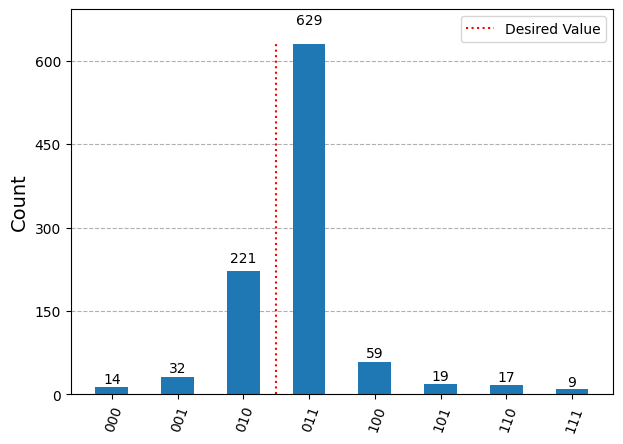

In [12]:
depth = 3
angle = 0.33
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e3)
result = job.result()
counts = result.get_counts()
print(counts)


success_probability = counts["011"] / counts.shots()          #https://www.rapidtables.com/convert/number/decimal-to-binary.html   0.25 --> 0.01 --> 010...000 ,erste 0 fällt weg
print(f"Success probability: {success_probability}")


fig, ax1 = plt.subplots(figsize=(7,5))

ax1 = plot_histogram(counts, ax = ax1)

plt.vlines(2.5 , 0 , max(counts.values()), color = "red", linestyle = "dotted", label = "Desired Value")
plt.legend()
plt.show()


{'00100': 14, '10110': 15, '11000': 13, '10101': 25, '11100': 12, '10010': 71, '11110': 12, '01010': 65, '01001': 33, '10001': 125, '11010': 9, '00101': 16, '10000': 369, '11111': 13, '11011': 6, '10111': 16, '10100': 31, '01011': 81, '00001': 7, '00110': 20, '01101': 471, '10011': 48, '01110': 5741, '01111': 2540, '01000': 26, '01100': 155, '00000': 10, '11001': 9, '11101': 10, '00011': 13, '00111': 19, '00010': 5}
Success probability: 0.5741


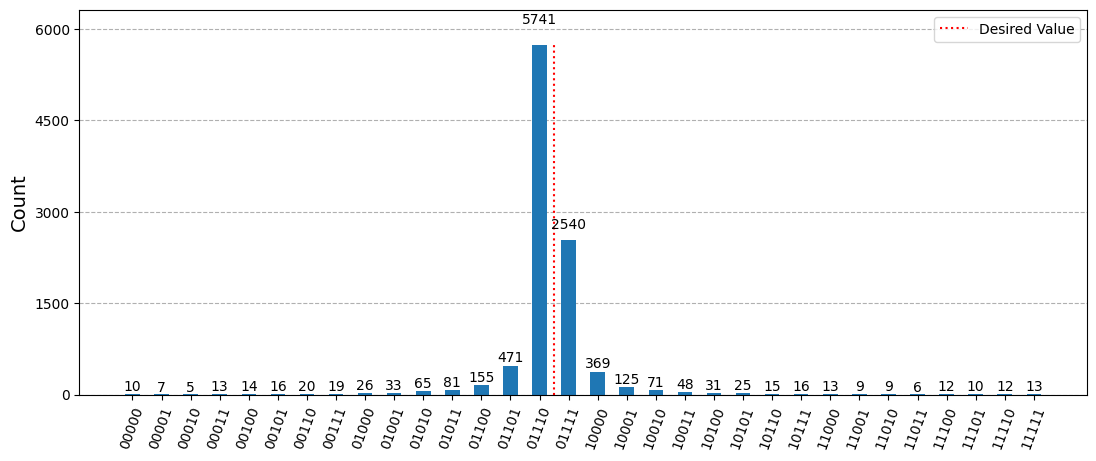

In [13]:
depth = 5
angle = 0.45
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e4)
result = job.result()
counts = result.get_counts()
print(counts)


success_probability = counts["01110"] / counts.shots()          #https://www.rapidtables.com/convert/number/decimal-to-binary.html   0.25 --> 0.01 --> 010...000 ,erste 0 fällt weg
print(f"Success probability: {success_probability}")


fig, ax1 = plt.subplots(figsize=(13,5))

ax1 = plot_histogram(counts, ax = ax1)

plt.vlines(14.5 , 0 , max(counts.values()), color = "red", linestyle = "dotted", label = "Desired Value")
plt.legend()
plt.show()


{'100': 4825, '101': 1976, '110': 1378, '001': 3666, '111': 1302, '011': 64453, '000': 1730, '010': 20670}


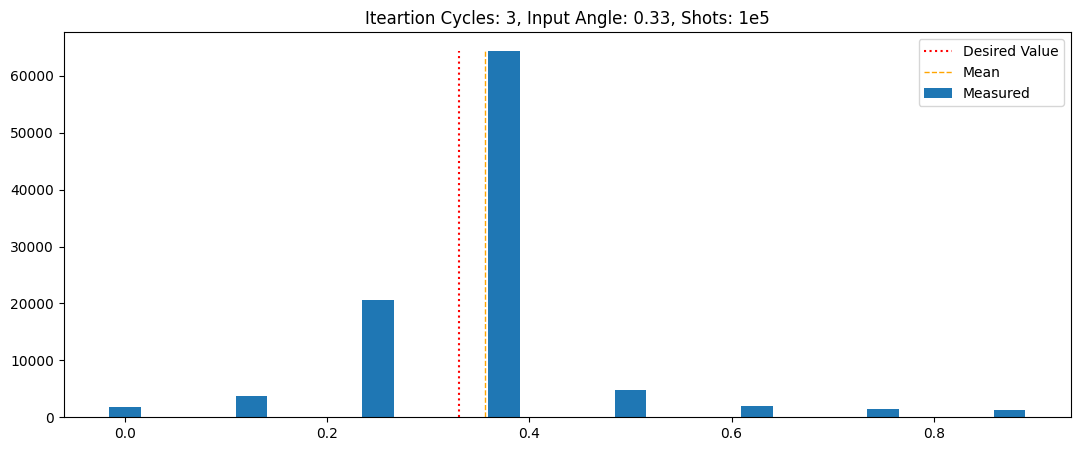

Difference between Mean of Mesurement and Desired Value:  0.02615875000000001
Theoretical precision of QPE with the same depth:  0.125
Improvement by  4.778515792994694

 Difference between Maximum Value of Mesurement and Desired Value:  0.044999999999999984
Improvement by  2.7777777777777786


In [14]:
depth = 3
angle = 0.33
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e5)
result = job.result()
counts = result.get_counts()
print(counts)

keys = counts.keys()
values = counts.values()

keys = [convert(i) for i in keys]
values = [i for i in values]

#print(keys)
#print(values)

fig, ax1 = plt.subplots(figsize=(13,5))

ax1 = plt.bar(keys, values, width = 2**(-depth-2), label="Measured")

avg = mean(keys, values)

plt.vlines(angle , 0 , max(values), color = "red", linestyle = "dotted", label = "Desired Value")
plt.vlines(avg, 0 , max(values), color='orange', linestyle='dashed', linewidth=1, label = "Mean")
plt.title("Iteration Cycles: 3, Input Angle: 0.33, Shots: 1e5")

plt.legend()
plt.show()

diff = np.abs(avg-angle)
print("Difference between Mean of Mesurement and Desired Value: ", diff)
theory = 2**(-depth)
print("Theoretical precision of QPE with the same depth: ", theory)
print("Improvement by ", theory/diff)

diff_max = diff_with_max(keys, values, angle)
print("\n Difference between Maximum Value of Mesurement and Desired Value: ", diff_max)
print("Improvement by ", theory/diff_max)

{'00011': 96, '11110': 94, '01001': 310, '10001': 1402, '00101': 131, '11010': 96, '01000': 262, '01100': 1602, '00111': 190, '01011': 807, '01101': 4674, '10010': 702, '11100': 93, '10101': 225, '00110': 157, '00001': 81, '01111': 25392, '10000': 3675, '10011': 465, '01110': 57463, '11101': 81, '01010': 513, '10111': 166, '10100': 339, '00010': 115, '11000': 126, '11011': 102, '11111': 106, '10110': 191, '00000': 96, '11001': 132, '00100': 116}


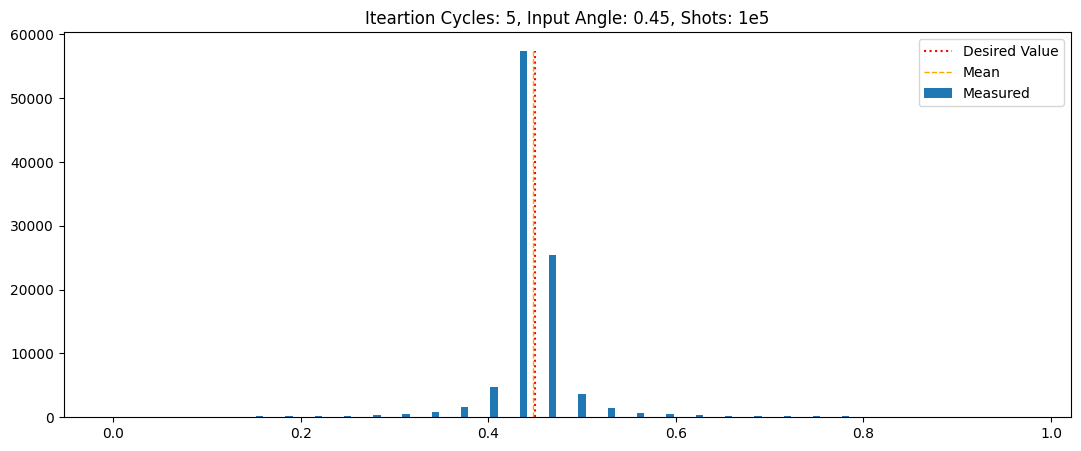

Difference between Mean of Mesurement and Desired Value:  0.0017206249999999756
Theoretical precision of QPE with the same depth:  0.03125
Improvement by  18.16200508536168

 Difference between Maximum Value of Mesurement and Desired Value:  0.012500000000000011
Improvement by  2.499999999999998


In [ ]:
depth = 5
angle = 0.45
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e5)
result = job.result()
counts = result.get_counts()
print(counts)

keys = counts.keys()
values = counts.values()

keys = [convert(i) for i in keys]
values = [i for i in values]

#print(keys)
#print(values)

fig, ax1 = plt.subplots(figsize=(13,5))

ax1 = plt.bar(keys, values, width = 2**(-depth-2), label="Measured")

avg= mean(keys, values)

plt.vlines(angle , 0 , max(values), color = "red", linestyle = "dotted", label = "Desired Value")
plt.vlines(avg, 0 , max(values), color='orange', linestyle='dashed', linewidth=1, label = "Mean")
plt.title("Iteration Cycles: 5, Input Angle: 0.45, Shots: 1e5")

plt.legend()
plt.show()

diff = np.abs(avg-angle)
print("Difference between Mean of Mesurement and Desired Value: ", diff)
theory = 2**(-depth)
print("Theoretical precision of QPE with the same depth: ", theory)
print("Improvement by ", theory/diff)


diff_max = diff_with_max(keys, values, angle)
print("\n Difference between Maximum Value of Mesurement and Desired Value: ", diff_max)
print("Improvement by ", theory/diff_max)

{'11010010': 1, '10111010': 1, '01111110': 1, '10000111': 1, '10001001': 1, '11111001': 1, '10111110': 1, '10110001': 1, '10101101': 4, '10100000': 47, '11110010': 1, '10001110': 1, '10011001': 7, '10110100': 2, '00110111': 2, '10101010': 14, '00011000': 1, '10100110': 50, '10010010': 2, '11000001': 2, '10101100': 10, '10011111': 32, '10011100': 7, '10111011': 1, '10100100': 586, '10000001': 2, '01010111': 1, '10100011': 98312, '10011101': 13, '10100111': 31, '10101001': 11, '10010111': 2, '10100101': 139, '00111100': 1, '10110000': 2, '10100001': 137, '10010100': 3, '10110010': 1, '10110110': 2, '10101000': 17, '11001101': 1, '10100010': 465, '11011111': 1, '10011010': 4, '10011011': 9, '10111100': 2, '00000100': 1, '10010011': 5, '10101011': 8, '10010001': 3, '10110101': 1, '11000011': 2, '01111100': 2, '01111000': 1, '11101111': 1, '10011110': 18, '10011000': 2, '11010011': 1, '10101111': 1, '11001001': 1, '00100000': 1, '01010010': 1, '10001000': 1, '10010101': 3, '10010110': 4, '1

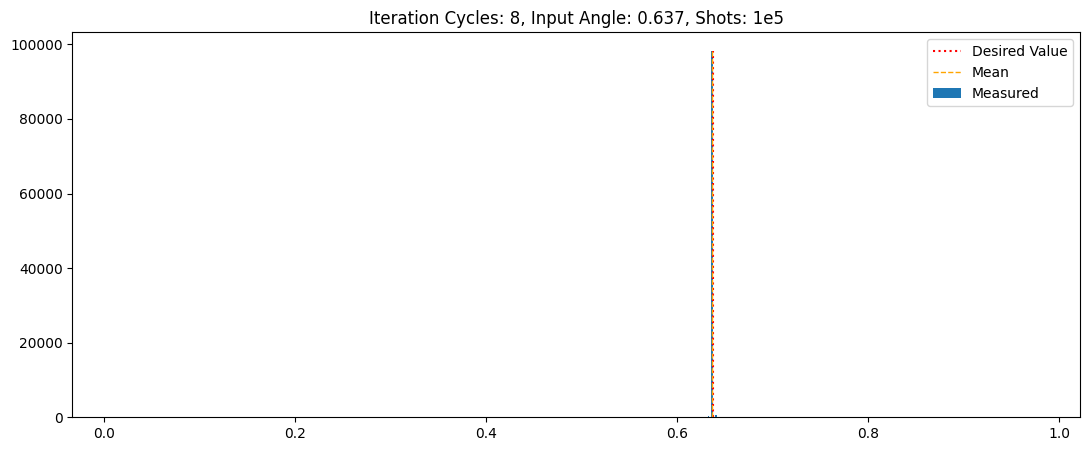

Difference between Mean of Mesurement and Desired Value:  0.00029984374999991736
Theoretical precision of QPE with the same depth:  0.00390625
Improvement by  13.027618551332408

 Difference between Maximum Value of Mesurement and Desired Value:  0.00028125000000001066
Improvement by  13.888888888888362


In [16]:
depth = 8
angle = 0.637
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e5)
result = job.result()
counts = result.get_counts()
print(counts)

keys = counts.keys()
values = counts.values()

keys = [convert(i) for i in keys]
values = [i for i in values]

#print(keys)
#print(values)

fig, ax1 = plt.subplots(figsize=(13,5))

ax1 = plt.bar(keys, values, width = 2**(-depth-1), label="Measured")

avg= mean(keys, values)

plt.vlines(angle , 0 , max(values), color = "red", linestyle = "dotted", label = "Desired Value")
plt.vlines(avg, 0 , max(values), color='orange', linestyle='dashed', linewidth=1, label = "Mean")
plt.title("Iteration Cycles: 8, Input Angle: 0.637, Shots: 1e5")

plt.legend()
plt.show()

diff = np.abs(avg-angle)
print("Difference between Mean of Mesurement and Desired Value: ", diff)
theory = 2**(-depth)
print("Theoretical precision of QPE with the same depth: ", theory)
print("Improvement by ", theory/diff)

diff_max = diff_with_max(keys, values, angle)
print("\n Difference between Maximum Value of Mesurement and Desired Value: ", diff_max)
print("Improvement by ", theory/diff_max)

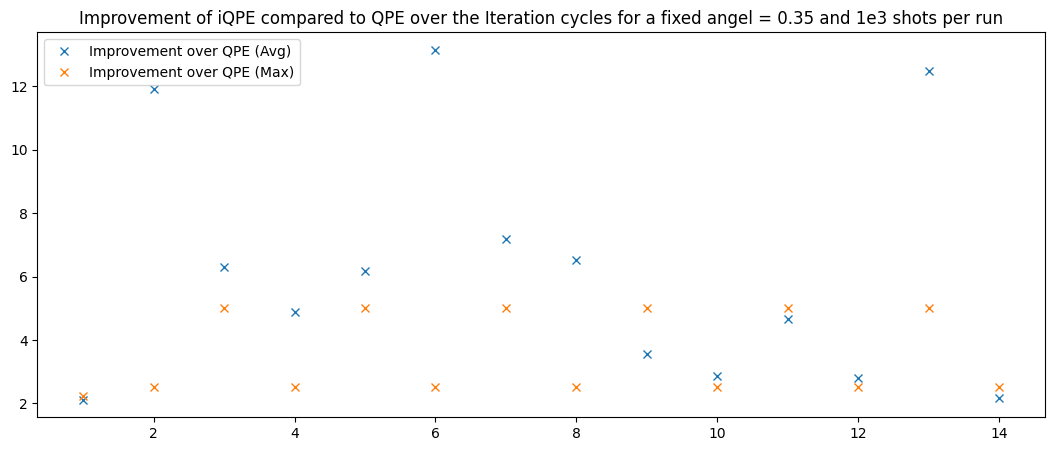

In [17]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit der Depth für fixed Winkel (Abwichung zum Average und zum Maximum Value)

overview = 15
angle = 0.35
list_improve_avg = []
list_improve_max = []
x = []
for i in range(1,overview):
    depth = i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=1e3)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg= mean(keys, values)
    diff = np.abs(avg-angle)
    theory = 2**(-depth)

    improve_avg = theory/diff
    list_improve_avg.append(improve_avg)

    diff_max = diff_with_max(keys, values, angle)
    improve_max= theory/diff_max
    list_improve_max.append(improve_max)

    x.append(i)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_improve_avg, "x", label="Improvement over QPE (Avg)")
ax = plt.plot(x, list_improve_max, "x", label="Improvement over QPE (Max)")
plt.title("Improvement of iQPE compared to QPE over the Iteration cycles for a fixed angel = 0.35 and 1e3 shots per run")
plt.legend()

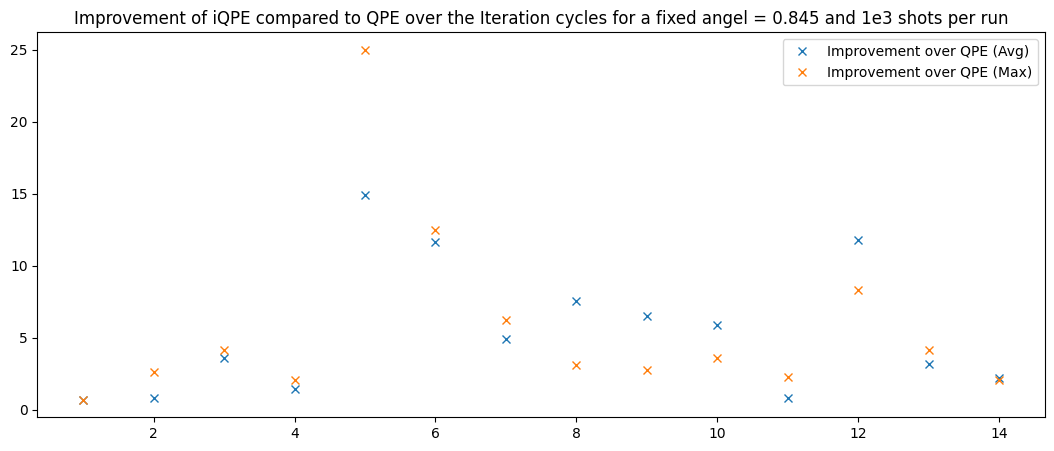

In [18]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit der Depth für fixed Winkel (Abwichung zum Average und zum Maximum Value)

overview = 15
angle = 0.845
list_improve_avg = []
list_improve_max = []
x = []
for i in range(1,overview):
    depth = i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=1e3)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg= mean(keys, values)
    diff = np.abs(avg-angle)
    theory = 2**(-depth)

    improve_avg = theory/diff
    list_improve_avg.append(improve_avg)

    diff_max = diff_with_max(keys, values, angle)
    improve_max= theory/diff_max
    list_improve_max.append(improve_max)

    x.append(i)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_improve_avg, "x", label="Improvement over QPE (Avg)")
ax = plt.plot(x, list_improve_max, "x", label="Improvement over QPE (Max)")
plt.title("Improvement of iQPE compared to QPE over the Iteration cycles for a fixed angel = 0.845 and 1e3 shots per run")
plt.legend()

In [19]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit des Winkels für fixed Depth (Abwichung zum Average und zum Maximum Value)

depth = 3
slices = 20
list_improve_avg = []
list_improve_max = []
x = []
for i in range(1, slices):
    angle = (1/slices)*i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=1e5)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg= mean(keys, values)
    diff = np.abs(avg-angle)
    theory = 2**(-depth)

    improve_avg = theory/diff
    list_improve_avg.append(improve_avg)

    diff_max = diff_with_max(keys, values, angle)
    improve_max= theory/diff_max
    list_improve_max.append(improve_max)

    x.append(angle)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_improve_avg, "x", label="Improvement over QPE (Avg)")
ax = plt.plot(x, list_improve_max, "x", label="Improvement over QPE (Max)")
plt.title("Improvement of iQPE compared to QPE over different angles for a fixed depth = 3 and 1e5 shots per run")
plt.legend()

In [20]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit des Winkels für fixed Depth (Abweichung zum Average und zum Maximum Value)

depth = 5
slices = 20
list_improve_avg = []
list_improve_max = []
x = []
for i in range(1, slices):
    angle = (1/slices)*i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=1e5)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg= mean(keys, values)
    diff = np.abs(avg-angle)
    theory = 2**(-depth)

    improve_avg = theory/diff
    list_improve_avg.append(improve_avg)

    diff_max = diff_with_max(keys, values, angle)
    improve_max= theory/diff_max
    list_improve_max.append(improve_max)

    x.append(angle)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_improve_avg, "x", label="Improvement over QPE (Avg)")
ax = plt.plot(x, list_improve_max, "x", label="Improvement over QPE (Max)")
plt.title("Improvement of iQPE compared to QPE over different angles for a fixed depth = 5 and 1e5 shots per run")
plt.legend()

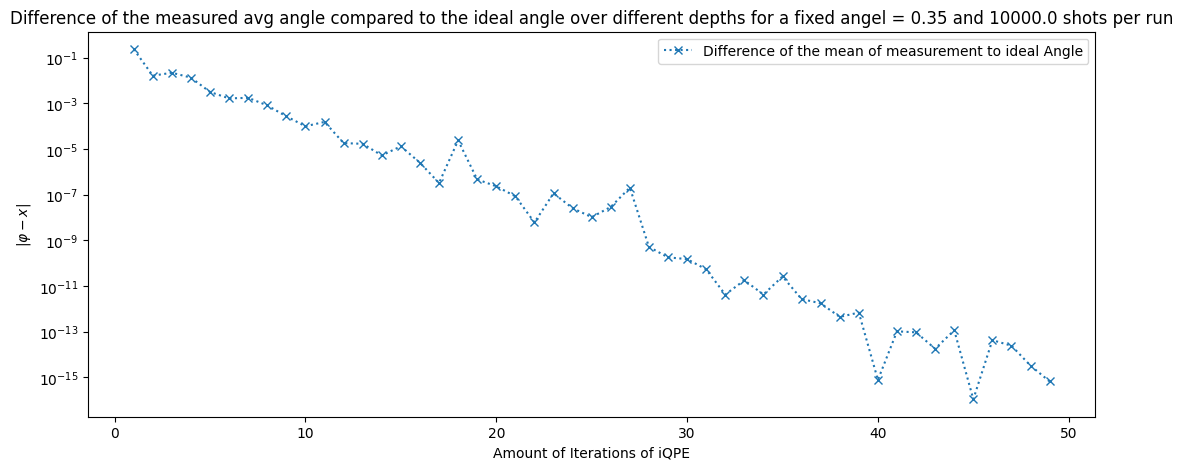

In [162]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit der Depth für fixed Winkel (So wie Leons Plot)

overview = 50
angle = 0.35
num = 1e4
list_diff = []
list_diff_max  = []
x = []
for i in range(1,overview):
    depth = i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=num)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg = mean(keys, values)
    diff = np.abs(avg-angle)
    list_diff.append(diff)

    diff_max = diff_with_max(keys, values, angle)
    list_diff_max.append(diff_max)

    x.append(i)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_diff, "x", label="Difference of the mean of measurement to ideal Angle", linestyle = "dotted")
#ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

plt.title("Difference of the measured avg angle compared to the ideal angle over different depths for a fixed angel = {} and {} shots per run".format(angle, int(num)))
plt.yscale("log")
plt.ylabel(r"$\vert \varphi - x \vert$")
plt.xlabel("Amount of Iterations of iQPE")
plt.legend()
#plt.savefig("test2.png", dpi = 300)
plt.show()

In [22]:
#Plot: Bei geforderter Präzision, wie reduziert sich die Anzahl der benötigten Shots geplotted über die Tiefe

def plot_requ_prec(precision: float, depth_range:int, angle: float, maxshots):
    list_shots = []
    x = []
    for i in range(1,depth_range):                                 #ab depth = 5 bekomme ich garantiert die 1e-4 precision, davor ist es Glückssache
        depth = i
        theta = 2*np.pi*angle
        qc = iqpe(theta,depth)

        sim = AerSimulator()
        for k in range(1,int(maxshots)):
            job = sim.run(qc, shots=k)
            result = job.result()
            counts = result.get_counts()

            keys = counts.keys()
            values = counts.values()

            keys = [convert(i) for i in keys]
            values = [i for i in values]
            avg = mean(keys, values)
            diff = np.abs(avg-angle)
            if diff <= precision:
                list_shots.append(k)
                break
            elif k==maxshots-1:
                list_shots.append(0)
                break
            else:
                continue

        x.append(i)

    fig, ax = plt.subplots(figsize=(13,5))

    ax = plt.plot(x, list_shots, "x", label="Shots needed", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

    plt.title("Amount of shots needed to achieve precision of {} for a fixed angle = {}".format(precision,angle))
    #plt.yscale("log")
    plt.ylabel("Shots required")
    plt.xlabel("Amount of Iterations of iQPE")
    plt.legend()

#plot_requ_prec(1e-3,20,0.33,1e3)

#plt.savefig("test6.png", dpi = 300)

In [23]:
#plot_requ_prec(1e-4,20,0.33,1e3)

#plt.savefig("test7.png", dpi = 300)

In [24]:
#plot_requ_prec(1e-5,20,0.33,1e3)

#plt.savefig("test8.png", dpi = 300)

In [25]:
#plot_requ_prec(1e-6,20,0.33,1e3)

#plt.savefig("test9.png", dpi = 300)

In [26]:
#plot_requ_prec(1e-7,20,0.33,1e3)

#plt.savefig("test10.png", dpi = 300)

In [33]:
#Plots, bei denen bei fester Depth die Präzision per Shotzahl geplottet wird

def plot_prec_per_shots(depth: int, start: float, end: float, angle: float, steps: float):
    maxshots = int(end)
    list = []
    x = []
    for k in range(int(start),maxshots, int(steps)):                                
        theta = 2*np.pi*angle
        qc = iqpe(theta,depth)
        sim = AerSimulator()
        job = sim.run(qc, shots=k)
        result = job.result()
        counts = result.get_counts()

        keys = counts.keys()
        values = counts.values()

        keys = [convert(i) for i in keys]
        values = [i for i in values]
        avg = mean(keys, values)
        diff = np.abs(avg-angle)
        list.append(diff)

        x.append(k)
    fig, ax = plt.subplots(figsize=(13,5))

    ax = plt.plot(x, list, "x", label="Precision", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

    plt.title(r"Difference of mean of each run $\varphi$ compared to the ideal angle $x$ plotted for different many shots for fixed depth d = {} and $x$ = {}".format(depth, angle))
    plt.yscale("log")
    plt.ylabel(r"$\vert \varphi - x \vert$")
    plt.xlabel("Shots")
    plt.legend()

In [ ]:
#plot_prec_per_shots(5, 1, 1e4, 0.6, 1)

#plt.savefig("test11.png", dpi = 300)

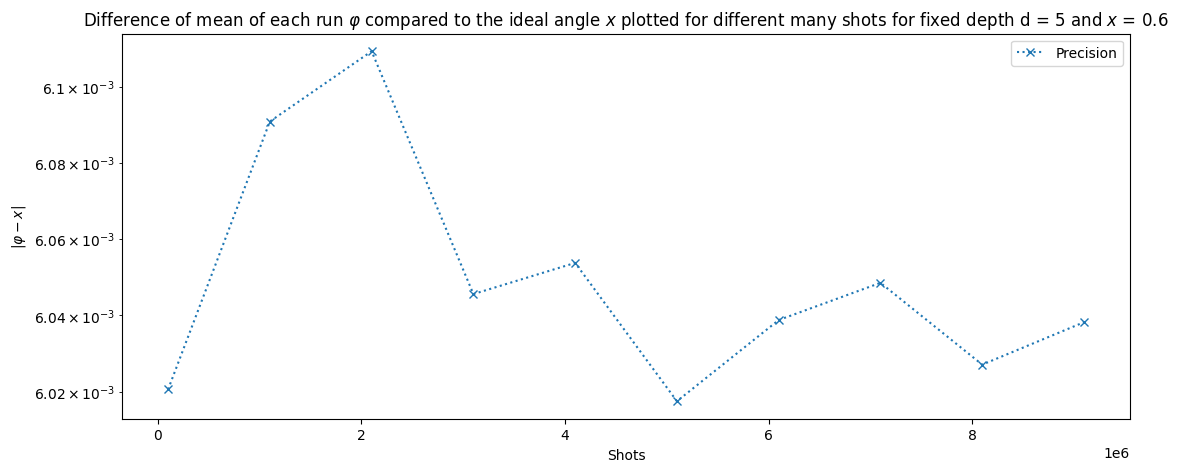

In [35]:
plot_prec_per_shots(5, 1e5, 1e7, 0.6, 1e6)

In [133]:
#Plots: Präzision(winkel), feste Shotzahl und Depth

def plot_prec_over_angle(depth:int, num: float, steps: int):
    list = []
    x = []
    angle = np.linspace(0,1,steps)
    for k in range(len(angle)-2):                                
        theta = 2*np.pi*(angle[k+1])
        qc = iqpe(theta,depth)
        sim = AerSimulator()
        job = sim.run(qc, shots=int(num))
        result = job.result()
        counts = result.get_counts()

        keys = counts.keys()
        values = counts.values()

        keys = [convert(i) for i in keys]
        values = [i for i in values]
        avg = mean(keys, values)
        diff = np.abs(avg-angle[k+1])
        list.append(diff)
        x.append(angle[k])
    fig, ax = plt.subplots(figsize=(13,5))
    ax = plt.plot(x, list, "x", label="Precision", linestyle = "dotted")
    plt.title(r"Difference of mean of each run $\varphi$ compared to the ideal angle $x$ plotted for different angles $\varphi$ for fixed depth d = {} and shots = {}".format(depth, int(num)))
    plt.yscale("log")
    plt.ylabel(r"$\vert \varphi - x \vert$plot_prec_over_angle(10, 1e4, 20)
# plt.savefig("test13.png", dpi = 300)
    plt.legend()



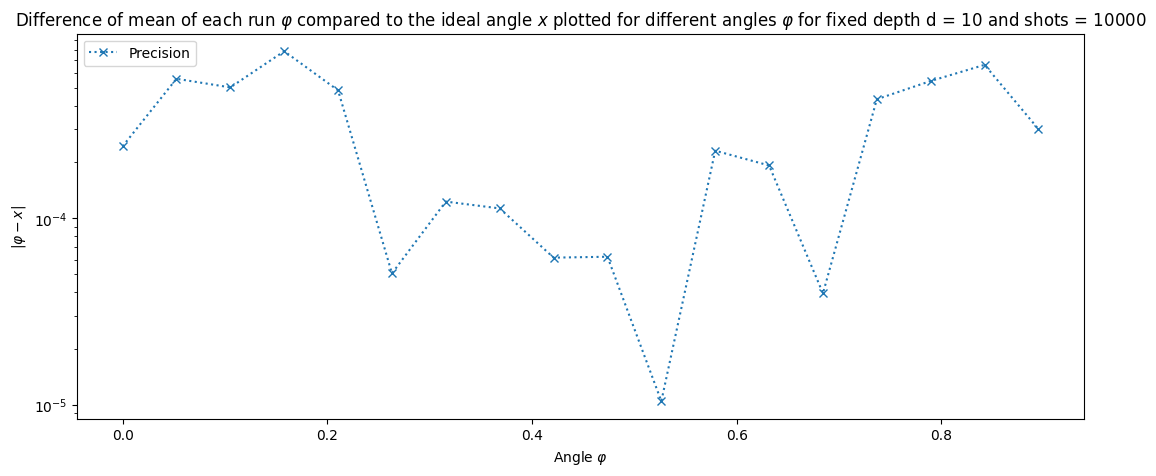

In [140]:
# plot_prec_over_angle(10, 1e4, 20)
# plt.savefig("test13.png", dpi = 300)

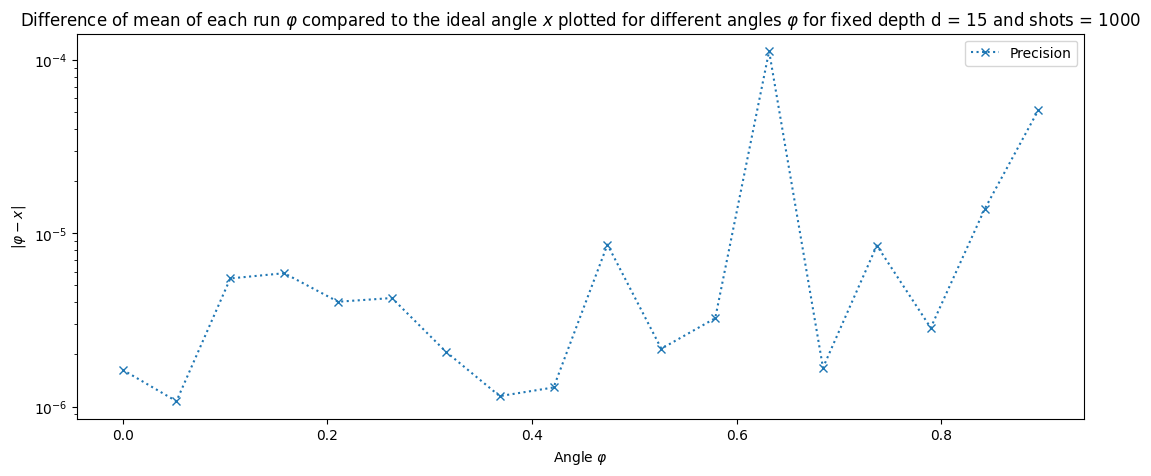

In [138]:
# plot_prec_over_angle(15, 1e4, 20)
# plt.savefig("test14.png", dpi = 300)

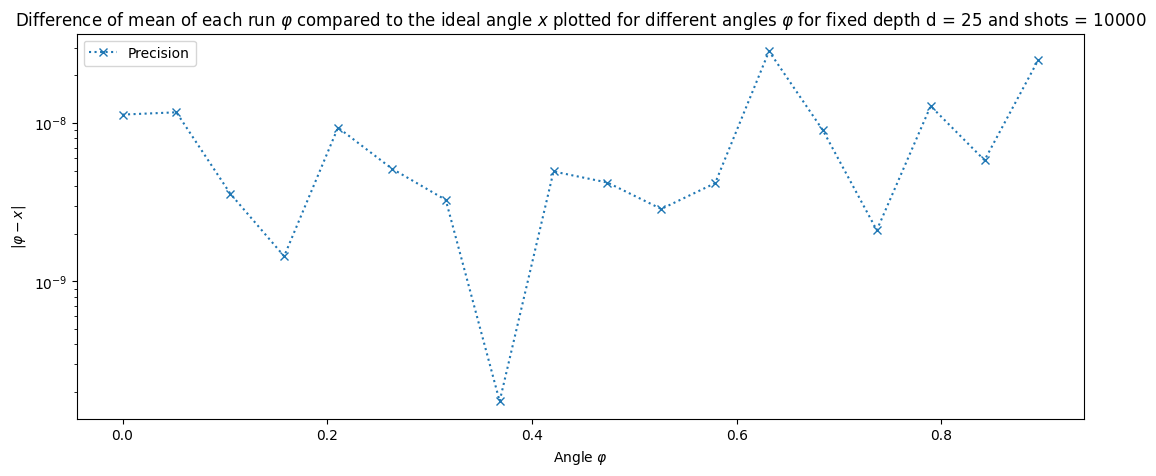

In [141]:
# plot_prec_over_angle(25, 1e4, 20)
# plt.savefig("test15.png", dpi = 300)

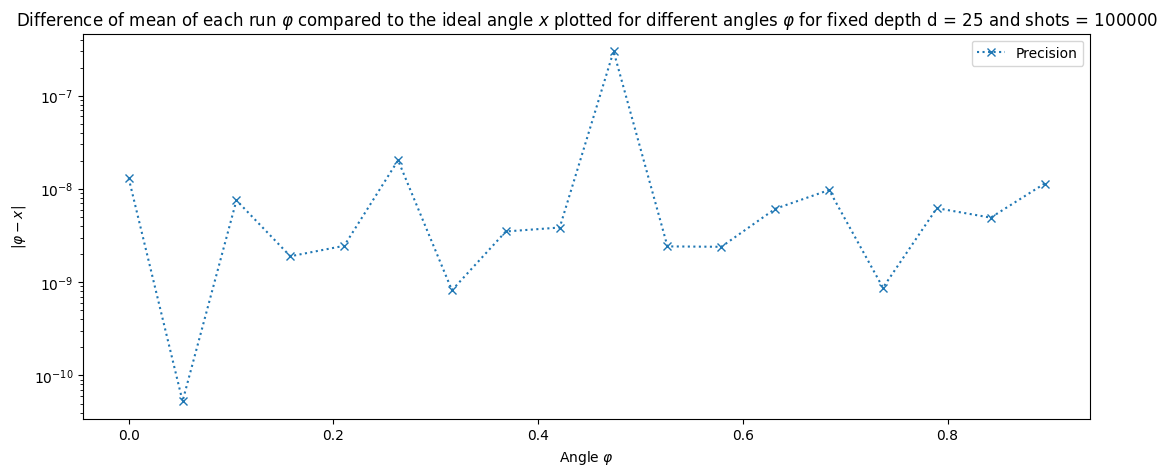

In [143]:
# plot_prec_over_angle(25, 1e5, 20)
# plt.savefig("test16.png", dpi = 300)

In [193]:
#Plot: Depth(Shots) bei fester Präzision und Winkel

def plot_depth_over_shots(precision:float, angle:float, maxdepth:int, shots_range:int, steps:int):
    list_depth = []
    x = []
    theta = 2*np.pi*angle
    stepss = np.linspace(0,shots_range,steps)

    for i in range(1,len(stepss)):

        for k in range(1,maxdepth):
            qc = iqpe(theta,k)
            sim = AerSimulator()
            job = sim.run(qc, shots=stepss[i])
            result = job.result()
            counts = result.get_counts()

            keys = counts.keys()
            values = counts.values()

            keys = [convert(i) for i in keys]
            values = [i for i in values]
            avg = mean(keys, values)
            diff = np.abs(avg-angle)
            if diff <= precision:
                list_depth.append(k)
                break
            elif k==maxdepth-1:
                list_depth.append(0)
                break
            else:
                continue
        x.append(stepss[i])

    fig, ax = plt.subplots(figsize=(13,5))

    ax = plt.plot(x, list_depth, "x", label="Depth of Circuit", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

    plt.title("Depth needed to achieve precision of {} for a fixed angle = {}".format(precision,angle))
    #plt.yscale("log")
    plt.ylabel("Depth")
    plt.ylim(0,maxdepth)
    plt.xlabel("Amount of Shots per Run")
    plt.legend()

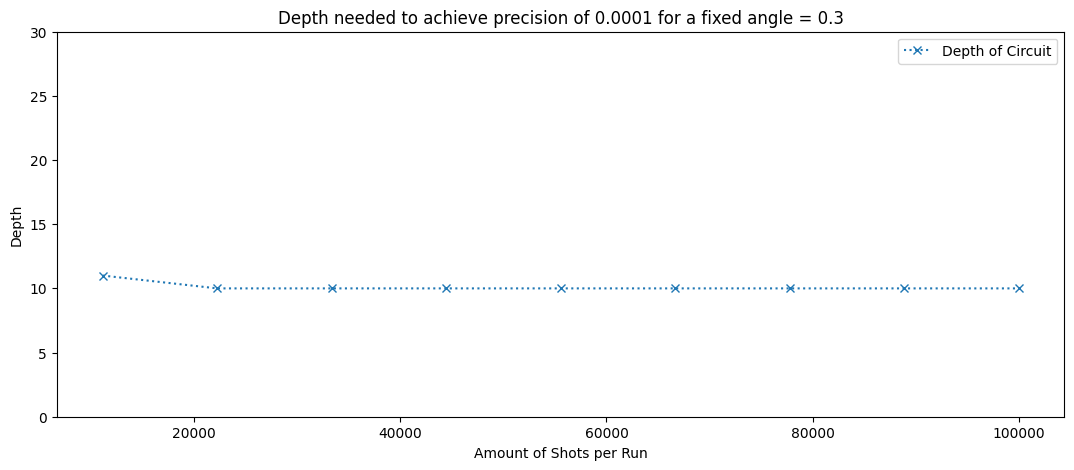

In [194]:
plot_depth_over_shots(1e-4, 0.3, 30, int(1e5), 10)

plt.savefig("test17.png", dpi = 300)

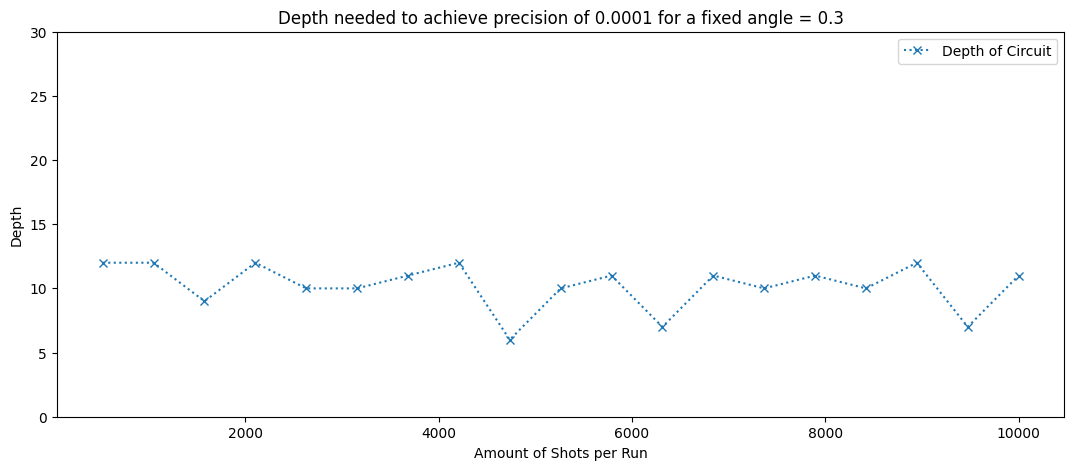

In [196]:
plot_depth_over_shots(1e-4, 0.3, 30, int(1e4), 20)

plt.savefig("test18.png", dpi = 300)

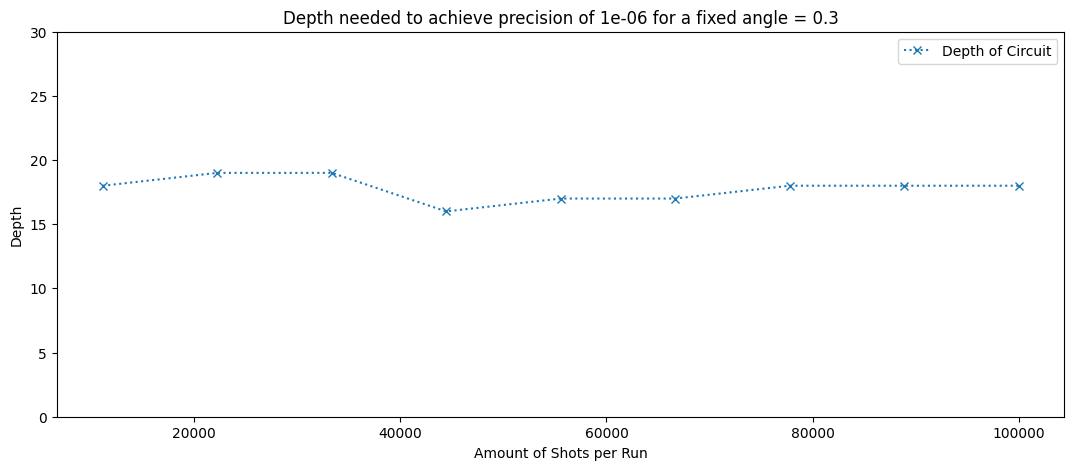

In [198]:
plot_depth_over_shots(1e-6, 0.3, 30, int(1e5), 10)

plt.savefig("test19.png", dpi = 300)